# Gradient boosting
In this model generation, I explore gradient boosting

In addition, the component ids are decomposed by Jingyi into component types 
and the related info.

In [1]:
%matplotlib inline
import os, glob
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from IPython.display import display
from pyearth import Earth

In [2]:
train = pd.read_csv(os.path.join('..','competition_data','train2.csv'),header=0,index_col=1)

In [3]:
train.columns

Index([u'Unnamed: 0', u'tube_assembly_id', u'supplier', u'bracket_pricing',
       u'quantity', u'cost', u'component_id_1_name', u'quantity_1',
       u'component_id_2_name', u'quantity_2', u'component_id_3_name',
       u'quantity_3', u'material_id', u'diameter', u'wall', u'length',
       u'num_bends', u'bend_radius', u'end_a_2x', u'end_x_2x', u'end_a',
       u'end_x', u'year', u'month', u'day'],
      dtype='object')

In [34]:
train[0:1]

,Unnamed: 0,tube_assembly_id,supplier,bracket_pricing,quantity,cost,component_id_1_name,quantity_1,component_id_2_name,quantity_2,...,length,num_bends,bend_radius,end_a_2x,end_x_2x,end_a,end_x,year,month,day
0,0,TA-00002,S-0066,Yes,1,21.905933,NUT-FLARED,2,NaN,0,...,137,8,19.05,N,N,EF-008,EF-008,2013,7,919


In the predictor data, the first two columns are unnecessary.

In [4]:
trainp = train.loc[:,['quantity', 
                      'component_id_1_name','quantity_1',
                      'component_id_2_name','quantity_2',
                      'component_id_3_name','quantity_3',
                      'material_id','diameter','wall','length',
                      'num_bends','bend_radius','end_a_2x',
                      'end_x_2x','end_a','end_x','year',
                      'month','day','cost']]

## Categorical variables pruning
The categorical variables such as material_id, component_id_x_name, 
end_x, end_a with string categories are converted to integer
labels. The values with high frequencies are retained and the low
frequency values (<100) are all combined into a single value

In [41]:
print trainp.component_id_1_name.value_counts()[0:16]
print trainp.component_id_2_name.value_counts()[0:9]
print trainp.component_id_3_name.value_counts()[0:5]

NUT-SWIVEL         9364
NUT-FLARED         4774
CONNECTOR-SEAL     1131
NUT                1130
NUT-INV FLARED      758
SLEEVE-ORFS         174
CONNECTOR           159
FLANGE              135
HEAD-FLANGED         96
BOSS                 93
ELBOW                85
SLEEVE               85
SLEEVE-FITTING       79
FLANGE-ONE PIEC      66
ELBOW-90 DEG         62
ELBOW-FLARED         48
dtype: int64
SLEEVE-ORFS         8873
SLEEVE-FLARED        886
SLEEVE               860
NUT-SWIVEL           564
CONNECTOR-SEAL       322
ELBOW-90 DEG         149
SLEEVE-FACE SEAL     132
NUT                  109
NUT-FITTING           79
dtype: int64
CONNECTOR-SEAL    2727
SLEEVE-ORFS        445
ELBOW-90 DEG       271
CONNECTOR          144
SLEEVE-REDUCER      91
dtype: int64


In [37]:
print sum(trainp.component_id_1_name.isnull().values)
print sum(trainp.component_id_2_name.isnull().values)
print sum(trainp.component_id_3_name.isnull().values)

477
6321
14741


In [5]:
lbl_enc = LabelEncoder()
lbl_enc.fit(trainp.component_id_1_name.values)  
print lbl_enc.classes_
comp_id1_trans = lbl_enc.transform(trainp.component_id_1_name.values)
from collections import defaultdict
d = defaultdict(int)
for i in comp_id1_trans:
    d[i] += 1
print d


for i in range(len(comp_id1_trans)):
    if d[comp_id1_trans[i]] < 135:
        comp_id1_trans[i] = 1 

d1 = defaultdict(int)
for i in comp_id1_trans:
    d1[i] += 1

print d1

[nan 'ADAPTER' 'ADAPTER-EXH PIP' 'ADAPTER-INLET' 'ADAPTER-O DRAIN'
 'ADAPTER-SUPPLY' 'BAR' 'BLOCK' 'BLOCK-DRAIN' 'BOSS' 'COLLAR' 'CONNECTOR'
 'CONNECTOR-FLARE' 'CONNECTOR-ORFS' 'CONNECTOR-SEAL' 'CONNECTOR-SPL'
 'CONNECTOR-WELD' 'COUPLET' 'COUPLET-WELD' 'COUPLING (1"BSP)' 'COUPLING AS'
 'ELBOW' 'ELBOW-90 DEG' 'ELBOW-90 DEGREE' 'ELBOW-FLARED' 'ELBOW-HYDRAULIC'
 'ELBOW-MANF IN' 'ELBOW-WATER' 'FITTING' 'FITTING-NUT' 'FLANGE'
 'FLANGE-ONE PIEC' 'FLANGE-ONE PIECE' 'FLANGE-SPL' 'HEAD-FLANGED' 'LINK'
 'MANIFOLD' 'NUT' 'NUT-45 (DEG)' 'NUT-A/C' 'NUT-FITTING' 'NUT-FLARED'
 'NUT-INV FLARED' 'NUT-SWIVEL' 'ORIFICE' 'PLATE' 'SEAL-O-RING' 'SLEEVE'
 'SLEEVE-FITTING' 'SLEEVE-ORFS' 'TEE-UNION' 'WASHER']
defaultdict(<type 'int'>, {0: 477, 1: 26, 2: 2, 3: 1, 4: 3, 5: 8, 6: 3, 7: 1, 8: 3, 9: 93, 10: 4, 11: 159, 12: 32, 13: 8, 14: 1131, 15: 8, 16: 40, 17: 3, 18: 6, 19: 4, 20: 13, 21: 85, 22: 62, 23: 8, 24: 48, 25: 16, 26: 2, 27: 1, 28: 43, 29: 8, 30: 135, 31: 66, 32: 4, 33: 8, 34: 96, 35: 1, 36: 8, 37: 1130,

/Users/mbkumar/venv2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:198: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/Users/mbkumar/venv2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:251: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


In [6]:
lbl_enc = LabelEncoder()
lbl_enc.fit(trainp.component_id_2_name.values)  
print lbl_enc.classes_
comp_id2_trans = lbl_enc.transform(trainp.component_id_2_name.values)
from collections import defaultdict
d = defaultdict(int)
for i in comp_id2_trans:
    d[i] += 1
print d
for i in range(len(comp_id2_trans)):
    if d[comp_id2_trans[i]] < 109:
        comp_id2_trans[i] = 1 

d2 = defaultdict(int)
for i in comp_id2_trans:
    d2[i] += 1

print d2

[nan 'ADAPTER' 'ADAPTER-INLET' 'ADAPTER-O RING' 'BLOCK' 'BOSS'
 'BOSS-FITTING' 'CONNECTOR' 'CONNECTOR-BHD' 'CONNECTOR-FLARE'
 'CONNECTOR-O-RIN' 'CONNECTOR-ORFS' 'CONNECTOR-SEAL' 'CONNECTOR-SPL'
 'CONNECTOR-SWIVEL' 'CONNECTOR-WELD' 'ELBOW' 'ELBOW-90 DEG'
 'ELBOW-90 DEGREE' 'ELBOW-90 DEGREES' 'ELBOW-HYDRAULIC' 'FLANGE'
 'FLANGE-4 BOLT' 'FLANGE-CAPTIVE' 'FLANGE-ONE PIEC' 'FLANGE-SADDLE'
 'FLANGE-WELD' 'HEAD O-RING' 'HEAD-FLANGED' 'LINK' 'NUT' 'NUT-45 (DEG)'
 'NUT-A/C' 'NUT-FITTING' 'NUT-FLARED' 'NUT-SWIVEL' 'PIN-DOWEL' 'PLATE'
 'PLUG' 'PLUG-O-RING' 'REDUCER' 'SLEEEVE-REDUCER' 'SLEEVE'
 'SLEEVE-FACE SEAL' 'SLEEVE-FITTING' 'SLEEVE-FLARED' 'SLEEVE-ORFS'
 'SLEEVE-REDUCER' 'STUD-WELD' 'TEE-ORFS TO BRA' 'TUBE' 'TUBE AS']
defaultdict(<type 'int'>, {0: 6321, 1: 32, 2: 3, 3: 8, 4: 8, 5: 23, 6: 6, 7: 72, 8: 19, 9: 56, 10: 6, 11: 16, 12: 322, 13: 19, 14: 40, 15: 29, 16: 55, 17: 149, 18: 16, 19: 2, 20: 8, 21: 38, 22: 6, 23: 8, 24: 18, 25: 3, 26: 5, 27: 8, 28: 38, 29: 6, 30: 109, 31: 8, 32: 8, 33: 79,

In [7]:
lbl_enc3 = LabelEncoder()
lbl_enc3.fit(trainp.component_id_3_name.values)  
print lbl_enc3.classes_
comp_id3_trans = lbl_enc3.transform(trainp.component_id_3_name.values)
from collections import defaultdict
d = defaultdict(int)
for i in comp_id3_trans:
    d[i] += 1
print d
for i in range(len(comp_id3_trans)):
    if d[comp_id3_trans[i]] < 100:
        comp_id3_trans[i] = 1 

d3 = defaultdict(int)
for i in comp_id3_trans:
    d3[i] += 1

print d3

[nan 'ADAPTER' 'ADAPTER-O LINE' 'ADAPTER-O SUPPL' 'ADAPTER-OIL LIN' 'BLOCK'
 'BLOCK-HYD' 'BOSS' 'CONNECTOR' 'CONNECTOR-BHD' 'CONNECTOR-ORFS'
 'CONNECTOR-SEAL' 'CONNECTOR-SPL' 'CONNECTOR-WELD' 'ELBOW' 'ELBOW-37 (DEG)'
 'ELBOW-90 (DEG)' 'ELBOW-90 DEG' 'ELBOW-90 DEGREE' 'ELBOW-HYDRAULIC'
 'FITTING' 'FLANGE' 'FLANGE-ONE PC' 'FLANGE-ONE PIEC' 'FLANGE-ONE PIECE'
 'HEAD FLANGED' 'HEAD-FLANGED' 'NUT-ORFS' 'NUT-SWIVEL' 'PLATE' 'PLUG-STOR'
 'SLEEVE' 'SLEEVE-FLARED' 'SLEEVE-ORFS' 'SLEEVE-REDUCER' 'TEE-FLARED'
 'TUBE' 'TUBE AS.']
defaultdict(<type 'int'>, {0: 14741, 1: 8, 2: 8, 3: 8, 4: 7, 5: 47, 6: 8, 7: 40, 8: 144, 9: 71, 10: 72, 11: 2727, 12: 16, 13: 64, 14: 35, 15: 16, 16: 20, 17: 271, 18: 24, 19: 4, 20: 8, 21: 32, 22: 2, 23: 1, 24: 4, 25: 8, 26: 16, 27: 7, 28: 48, 29: 5, 30: 2, 31: 35, 32: 32, 33: 445, 34: 91, 35: 8, 36: 3, 37: 8})
defaultdict(<type 'int'>, {0: 14741, 33: 445, 1: 758, 8: 144, 11: 2727, 17: 271})


In [8]:
comp_id1_trans = np.expand_dims(comp_id1_trans,axis=1)
comp_id2_trans = np.expand_dims(comp_id2_trans,axis=1)
comp_id3_trans = np.expand_dims(comp_id3_trans,axis=1)
#enc_comp_id1 = OneHotEncoder()
#enc_comp_id1.fit(  
#print enc_comp_id1.n_values_
#enc_end.feature_indices_
#end_trans = enc_end.transform(end_vals).toarray()
#np.shape(end_trans)

In [45]:
trainp.material_id.value_counts()

SP-0029    10117
SP-0035     3222
SP-0039     2614
SP-0019     2407
SP-0028      572
SP-0036       48
SP-0046       29
SP-0048        9
SP-0033        6
SP-0030        6
SP-0038        2
SP-0031        2
SP-0037        2
dtype: int64

The first four material ids have high frequencies. Its better to assign those 4 to 
different values and group the rest into a single value

In [9]:
material_id_map = {'SP-0029': 0, 'SP-0035': 1, 'SP-0039': 2,
                   'SP-0019': 3, 'SP-0028': 5, 'SP-0036': 4,
                   'SP-0046': 4, 'SP-0048': 4, 'SP-0033': 4,
                   'SP-0030': 4, 'SP-0038': 4, 'SP-0031': 4, 
                   'SP-0037': 4, 
                  }
trainp1 = trainp.copy()
for key,value in material_id_map.items():
    trainp1.material_id[trainp1.material_id==key] = value
trainp1.material_id[trainp1.material_id.isnull()] = 4

/Users/mbkumar/venv2/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mbkumar/venv2/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
material_id_vals = trainp1.material_id.values
#preprocessing.OneHotEncoder
material_id_vals = np.reshape(material_id_vals,(len(material_id_vals),1))
material_id_vals

array([[3],
       [3],
       [3],
       ..., 
       [1],
       [1],
       [1]], dtype=object)

In [13]:
#enc = OneHotEncoder()
#enc.fit(material_id_vals)  
#enc.n_values_
#enc.feature_indices_
#mat_id_trans = enc.transform(material_id_vals).toarray()
#mat_id_trans

In [48]:
trainp1.end_a.value_counts()

EF-003    11252
EF-008     4920
EF-018     1854
NONE        421
EF-017      246
EF-009      151
EF-023      151
EF-012       32
EF-013       17
EF-021       12
EF-016       12
EF-006        8
EF-002        4
EF-010        2
EF-019        2
EF-022        1
EF-007        1
dtype: int64

In [16]:
trainp1.end_x.value_counts()

EF-003    10975
EF-008     4911
EF-018     1824
NONE        562
EF-017      380
EF-023      173
EF-009      132
EF-006       38
EF-012       26
EF-013       24
EF-021       12
EF-016       11
EF-010        6
EF-004        5
EF-002        4
9999          2
EF-019        1
dtype: int64

In [11]:
end_map = {'EF-003': 0, 'EF-008': 1, 'EF-018': 2, 'NONE': 4, 
           'EF-017': 5, 'EF-009': 6, 'EF-023': 7, 'EF-012': 3, 
           'EF-013': 3, 'EF-021': 3, 'EF-016':  3, 'EF-006': 3, 
           'EF-002': 3, 'EF-010': 3, 'EF-019': 3,'EF-022': 3,
           'EF-007': 3, 'EF-004': 3}

In [12]:
trainp2 = trainp1.copy()
for key,value in end_map.items():
    trainp2.end_a[trainp2.end_a==key] = value
    trainp2.end_x[trainp2.end_x==key] = value
trainp2.end_a[trainp2.end_a.isnull()] = 4
trainp2.end_x[trainp2.end_x.isnull()] = 4
end_a_vals = trainp2.end_a.values
#preprocessing.OneHotEncoder
end_a_vals = np.reshape(end_a_vals,(len(end_a_vals),1))
end_x_vals = trainp2.end_x.values
end_x_vals = np.reshape(end_x_vals,(len(end_x_vals),1))
end_vals = np.concatenate((end_a_vals, end_x_vals), axis=1)
end_vals[1000:1010]

/Users/mbkumar/venv2/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/mbkumar/venv2/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mbkumar/venv2/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mbkumar/venv2/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: Se

array([[1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=object)

In [58]:
#enc_end = OneHotEncoder()
#enc_end.fit(end_vals)  
#print enc_end.n_values_
#enc_end.feature_indices_
#end_trans = enc_end.transform(end_vals).toarray()
#np.shape(end_trans)

In [13]:
#trainp1.end_x_2x.value_counts()
trainp3 = trainp2.copy()
trainp3.end_x_2x[trainp3.end_x_2x=='N'] = 0
trainp3.end_x_2x[trainp3.end_x_2x=='Y'] = 1
trainp3.end_a_2x[trainp3.end_a_2x=='N'] = 0
trainp3.end_a_2x[trainp3.end_a_2x=='Y'] = 1
trainp3[0:10]

/Users/mbkumar/venv2/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/mbkumar/venv2/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mbkumar/venv2/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mbkumar/venv2/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: Se

,quantity,component_id_1_name,quantity_1,component_id_2_name,quantity_2,component_id_3_name,quantity_3,material_id,diameter,wall,...,num_bends,bend_radius,end_a_2x,end_x_2x,end_a,end_x,year,month,day,cost
0,1,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,21.905933
1,2,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,12.341214
2,5,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,6.601826
3,10,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,4.687770
4,25,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,3.541561
5,50,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,3.224406
6,100,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,3.082521
7,250,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,2.999060
8,1,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,9,19.05,0,0,1,1,2013,7,919,21.972702
9,2,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,9,19.05,0,0,1,1,2013,7,919,12.407983


In [52]:
trainp3.columns

Index([u'quantity', u'component_id_1_name', u'quantity_1',
       u'component_id_2_name', u'quantity_2', u'component_id_3_name',
       u'quantity_3', u'material_id', u'diameter', u'wall', u'length',
       u'num_bends', u'bend_radius', u'end_a_2x', u'end_x_2x', u'end_a',
       u'end_x', u'year', u'month', u'day', u'cost'],
      dtype='object')

In [14]:
trainp4 = trainp3.loc[:,[u'quantity', 
       'quantity_1','quantity_2','quantity_3', 
       'diameter', u'wall', u'length',
       'num_bends', u'bend_radius', u'end_a_2x', u'end_x_2x',
       'year', u'month', u'day', u'cost']]
# Reencode the categorical variables
trainp4.insert(1, 'component_id_1_name', comp_id1_trans, allow_duplicates=False)
trainp4.insert(3, 'component_id_2_name', comp_id2_trans, allow_duplicates=False)
trainp4.insert(5, 'component_id_3_name', comp_id3_trans, allow_duplicates=False)
trainp4.insert(2, 'material_id', material_id_vals, allow_duplicates=False)
trainp4.insert(9, 'end_a', end_a_vals, allow_duplicates=False)
trainp4.insert(10, 'end_x', end_x_vals, allow_duplicates=False)
trainp4.columns


Index([           u'quantity', u'component_id_1_name',         u'material_id',
                u'quantity_1', u'component_id_2_name',          u'quantity_2',
       u'component_id_3_name',          u'quantity_3',            u'diameter',
                     u'end_a',               u'end_x',                u'wall',
                    u'length',           u'num_bends',         u'bend_radius',
                  u'end_a_2x',            u'end_x_2x',                u'year',
                     u'month',                 u'day',                u'cost'],
      dtype='object')

In [ ]:
#trainp4.to_csv(os.path.join('..','competition_data','train_model_attempt2_final_data.csv'))

In [15]:
X_cols = trainp4.columns[:-1]
print X_cols
print len(trainp4)


Index([           u'quantity', u'component_id_1_name',         u'material_id',
                u'quantity_1', u'component_id_2_name',          u'quantity_2',
       u'component_id_3_name',          u'quantity_3',            u'diameter',
                     u'end_a',               u'end_x',                u'wall',
                    u'length',           u'num_bends',         u'bend_radius',
                  u'end_a_2x',            u'end_x_2x',                u'year',
                     u'month',                 u'day'],
      dtype='object')
19086


In [16]:
from sklearn import cross_validation

# Randomize the data

In [17]:
trainp5 = trainp4.iloc[np.random.permutation(len(trainp4))]

In [21]:
#X_cols = ['diameter','wall','length','num_bends','bend_radius',
#          'quantity','year','month','day']
train_X = trainp5.as_matrix(trainp5.columns[:-1])
train_y = trainp5.as_matrix(['cost'])[:,0]
#print train_X[0]
#train_y


In [19]:
gbr = GradientBoostingRegressor(n_estimators=1000,max_depth=4)

In [67]:
scores = cross_validation.cross_val_score(gbr, train_X, train_y, cv=10)
scores

array([ 0.88986142,  0.40656068,  0.73099164,  0.8145523 ,  0.92056794,
        0.83957556,  0.79412001,  0.78966247,  0.88580281,  0.56252026])

In [69]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.76 (+/- 0.31)


In [70]:
gbr.fit(train_X,train_y)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

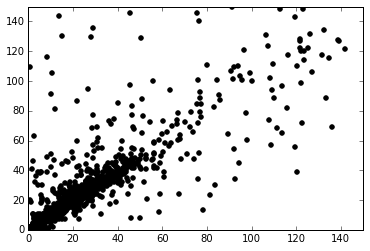

In [22]:
pred_y = cross_validation.cross_val_predict(gbr, train_X, train_y, cv=10)
plt.scatter(train_y, pred_y,  color='black')
plt.xlim((0,150))
plt.ylim ((0,150))

plt.show()

In [25]:
from sklearn import metrics
metrics.r2_score(train_y, pred_y)

0.76091321422790725

In [26]:
gbr.get_params()

{'alpha': 0.9,
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [29]:
param_grid = [
    {'max_depth': [2,3,4,5,6,7], 'min_samples_split': [2,3,4,5], 
     'learning_rate': [0.1,0.15,0.2,0.25,0.3],
     'n_estimators': [100, 500, 1000, 1500, 2000, 2500, 3000],
     'subsample': [0.5,0.6,0.7,0.8,0.9], 'loss': ['ls', 'lad']}
]

In [28]:
from sklearn.grid_search import GridSearchCV

In [31]:
gs_clf = GridSearchCV(gbr, param_grid=param_grid, cv=10, scoring='r2', n_jobs=4)

In [ ]:
gs_clf.fit(train_X,train_y)